# Classification Models and Hyperparameter Finetuning

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier
)
from sklearn.svm import SVC
from xgboost import XGBClassifier


### path and file

In [2]:
path = r"C:\Users\eitanb\Documents\GitHub\ML_Football_DS18\DATA"
path_result = r"C:\Users\eitanb\Documents\GitHub\ML_Football_DS18\result"

In [3]:
#importing model data
df_model=pd.read_csv(path_result+"/"+'model_after_feature_selection_prediction_during_game.csv', index_col=0)

### Split the data to tarin 80% and test 20% 

In [4]:
# Ensure the target column 'result' exists in the dataset
if 'result' in df_model.columns:
    # Define target
    y = df_model['result']
    
    # Define features by dropping the target column
    X = df_model.drop(columns=['result'])

    # Split into train and test sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    # Show the shapes of the resulting sets
    split_shapes = {
        "X_train": X_train.shape,
        "X_test": X_test.shape,
        "y_train": y_train.shape,
        "y_test": y_test.shape
    }
else:
    split_shapes = "❌ Column 'result' not found in dataset."

split_shapes


{'X_train': (10144, 27),
 'X_test': (2536, 27),
 'y_train': (10144,),
 'y_test': (2536,)}

### model run throw 8 calssification model  

In [5]:

# Classification metrics function
def classificationMetrics(y_true, y_pred, y_proba=None):
    precision, recall, f1, _ = metrics.precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )

    result = {
        'Accuracy': metrics.accuracy_score(y_true, y_pred),
        'Precision': precision,
        'Recall': recall,
        'f1-score': f1
    }

    if y_proba is not None:
        try:
            result['Log-loss'] = metrics.log_loss(y_true, y_proba)
            result['AUC'] = metrics.roc_auc_score(y_true, y_proba, multi_class='ovr')
        except:
            result['Log-loss'] = None
            result['AUC'] = None
    else:
        result['Log-loss'] = None
        result['AUC'] = None

    return result


In [6]:
def get_feature_importance(model, feature_names):
    """
    Returns a sorted list of (feature_name, importance) tuples for a fitted model.
    
    Supports both tree-based models and linear models.
    """
    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = model.coef_[0]  # for binary classification
        else:
            return None

        feature_importance = list(zip(feature_names, importances))
        return sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)
    except Exception:
        return None


In [7]:


models_list = pd.DataFrame()
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
    ("SVM", SVC(probability=True)),
    ("Extra Trees", ExtraTreesClassifier())
]

# Store metrics and confusion matrices
models_list = pd.DataFrame()
confusion_matrices = {}
importance_feature={}
importance_rows = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    try:
        y_proba = model.predict_proba(X_test)
    except:
        y_proba = None

    # Metrics
    model_dict = {'Model': name}
    metrics_dict = classificationMetrics(y_test, y_pred, y_proba)
    row = pd.DataFrame([{**model_dict, **metrics_dict}])
    models_list = pd.concat([models_list, row], ignore_index=True)

    # Confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm

    # importence features by model
    # Feature importance
    importance_feature[name] = get_feature_importance(model, X_train.columns)

models_list


,Model,Accuracy,Precision,Recall,f1-score,Log-loss,AUC
0,Logistic Regression,0.735410,0.703540,0.699153,0.699561,0.599469,0.882633
1,Decision Tree,0.696372,0.669571,0.667955,0.668630,10.943854,0.757580
2,Random Forest,0.768533,0.741974,0.734727,0.735200,0.571391,0.905094
3,AdaBoost,0.732650,0.708296,0.701302,0.703917,1.028839,0.845061
4,Gradient Boosting,0.784700,0.763293,0.759816,0.761329,0.494114,0.925098
5,XGBoost,0.820978,0.801544,0.794263,0.796709,0.430875,0.942299
6,SVM,0.436909,0.145636,0.333333,0.202708,0.884034,0.755144
7,Extra Trees,0.776814,0.752512,0.742816,0.743775,0.584587,0.910641


### confusion matrix for every model

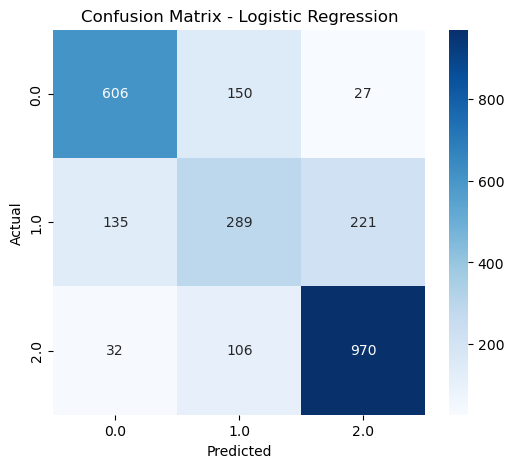

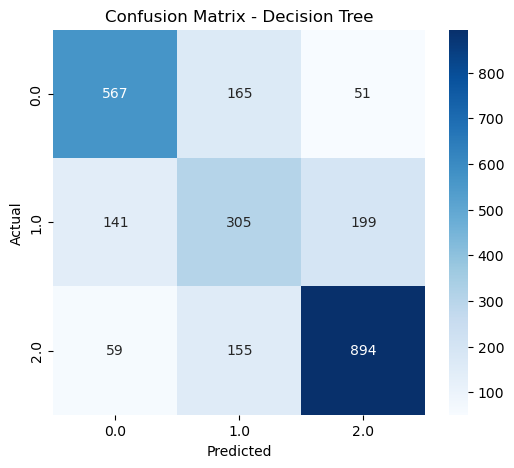

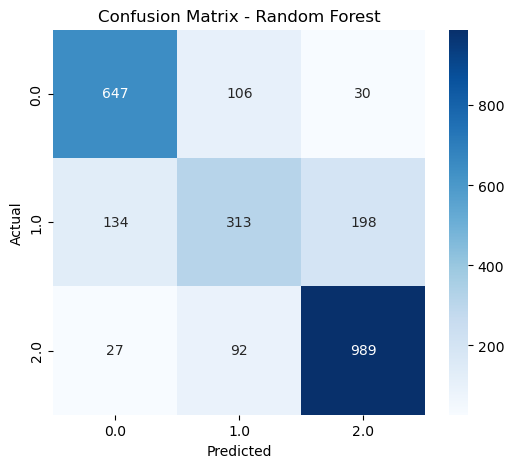

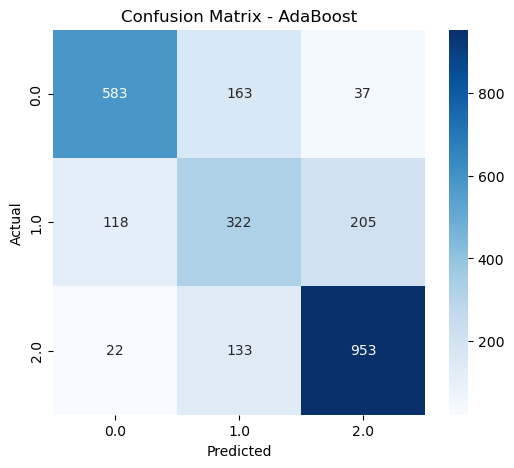

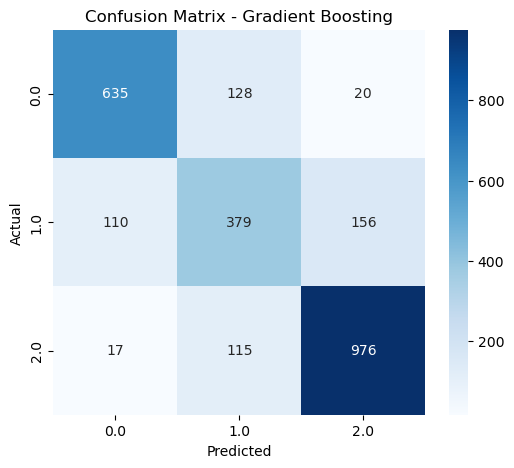

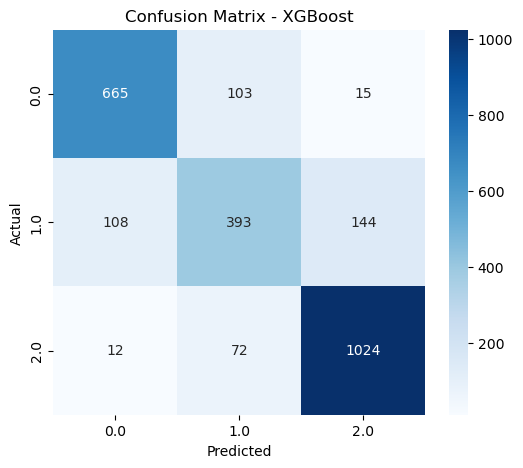

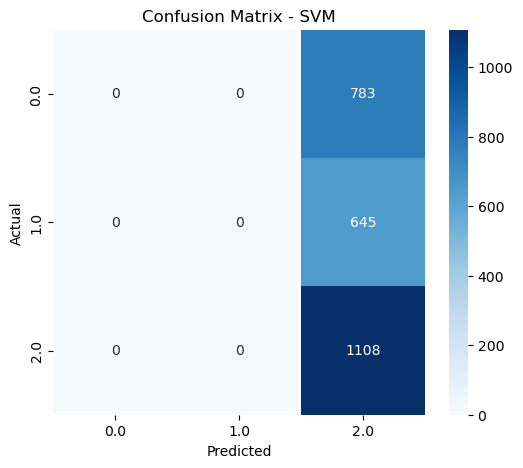

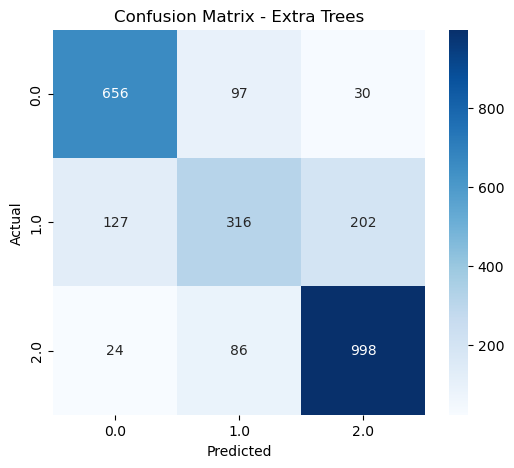

In [8]:
def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
labels = sorted(y_test.unique())  # Get sorted class labels from your y_test

for model_name in models_list['Model']:
    conf_m = confusion_matrices.get(model_name)
    if conf_m is not None:
        plot_confusion_matrix(conf_m, labels, title=f"Confusion Matrix - {model_name}")
    else:
        print(f"No confusion matrix found for {model_name}")


In [9]:
importance_df = pd.DataFrame(importance_feature)
importance_df

,Logistic Regression,Decision Tree,Random Forest,AdaBoost,Gradient Boosting,XGBoost,SVM,Extra Trees
0,"(total_assists_a_cat, 1.1299950273882498)","(total_assists_a_cat, 0.23542459920983702)","(total_assists_h_cat, 0.14804269115897445)","(total_assists_h_cat, 0.3662438342668996)","(total_assists_a_cat, 0.3756443903642273)","(total_assists_h_cat, 0.2594238)",None,"(total_assists_h_cat, 0.1493073178993671)"
1,"(total_assists_h_cat, -0.8837214352375264)","(total_assists_h_cat, 0.20681934199285135)","(total_assists_a_cat, 0.1370902652386262)","(total_assists_a_cat, 0.26598404343347)","(total_assists_h_cat, 0.37466947572382286)","(total_assists_a_cat, 0.24836856)",None,"(total_assists_a_cat, 0.1399387866988223)"
2,"(shotsOnTarget_a, 0.525500992713608)","(xGoals_h, 0.06065554559636487)","(total_xGoalsChain_a, 0.05802624402942614)","(xGoals_h, 0.10020186407144176)","(shotsOnTarget_h, 0.05444203613669486)","(shotsOnTarget_h, 0.042144846)",None,"(shotsOnTarget_h, 0.05404900625600066)"
3,"(shotsOnTarget_h, -0.41682685279889475)","(xGoals_a, 0.04601926003875824)","(xGoals_h, 0.054963613663665124)","(shotsOnTarget_h, 0.07391499618071246)","(shotsOnTarget_a, 0.04468207594428474)","(shotsOnTarget_a, 0.041829374)",None,"(shotsOnTarget_a, 0.05165411205753037)"
4,"(total_saved_shots_a, -0.19400397291757343)","(total_xGoalsChain_h, 0.03473569264096219)","(xGoals_a, 0.05297765512923186)","(shotsOnTarget_a, 0.07033938508775675)","(xGoals_h, 0.03305854270601277)","(total_saved_shots_h, 0.04070302)",None,"(xGoals_h, 0.04610371323624518)"
5,"(xGoals_h, -0.1758426427164255)","(total_xGoalsChain_a, 0.031096880805270313)","(total_xGoalsChain_h, 0.05248870042523374)","(xGoals_a, 0.06640212796202521)","(xGoals_a, 0.03038288210125684)","(total_saved_shots_a, 0.036916707)",None,"(total_xGoalsChain_a, 0.044760263790122545)"
6,"(xGoals_a, 0.12214413227230388)","(ppda_h, 0.030137749279845614)","(shotsOnTarget_h, 0.04846496269060445)","(total_xGoalsChain_a, 0.02401102432682619)","(total_saved_shots_h, 0.02114332066318416)","(xGoals_h, 0.031240836)",None,"(xGoals_a, 0.04123362678388256)"
7,"(total_xGoalsChain_h, -0.11554305935535099)","(shotsOnTarget_h, 0.02989748163377707)","(shotsOnTarget_a, 0.04468165691949299)","(total_saved_shots_a, 0.01764893027319371)","(total_saved_shots_a, 0.01643632193794193)","(xGoals_a, 0.02740247)",None,"(total_xGoalsChain_h, 0.036711743584078554)"
8,"(total_saved_shots_h, 0.10605616480309904)","(shotsOnTarget_a, 0.026622046383191933)","(ppda_h, 0.03167035044097296)","(total_key_passes_h, 0.015253794397674448)","(total_xGoalsChain_a, 0.009375836637680214)","(total_key_passes_a, 0.02136617)",None,"(total_saved_shots_h, 0.028004492439337385)"
9,"(total_xGoalsChain_a, 0.10403934342845288)","(ppda_a, 0.02582201397955729)","(ppda_a, 0.030867002926450535)","(season, 0.0)","(total_xGoalsChain_h, 0.006846907302005894)","(total_key_passes_h, 0.020969681)",None,"(total_saved_shots_a, 0.0272108541225173)"


## XGBoost provides the best results with 82% accuracy

### Hyperparameter Finetuning

In [10]:
%pip install --upgrade xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
import numpy as np

from xgboost import XGBClassifier

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=0
)


from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define parameter space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'gamma': [0, 1, 5]}

# Set up randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring=make_scorer(f1_score, average='macro'),
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run it!
random_search.fit(X_train, y_train)

# Get the best model and performance
best_xgb = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print("✅ Best Parameters:", best_params)
print("🎯 Best F1 Score (CV):", best_score)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict on the test set
y_pred = best_xgb.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')  # use 'binary' for binary classification
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Store results
result = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'f1-score': f1
}

print("📊 Evaluation Metrics:")
for k, v in result.items():
    print(f"{k}: {v:.4f}")


Note: you may need to restart the kernel to use updated packages.
Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Best Parameters: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.7}
🎯 Best F1 Score (CV): 0.792757842253348
📊 Evaluation Metrics:
Accuracy: 0.8170
Precision: 0.7970
Recall: 0.7909
f1-score: 0.7928


In [11]:
print("✅ Best Parameters:", best_params)

✅ Best Parameters: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.7}


### The best parameters result got lowe F1 score and accuracy then the defult result 

In [12]:
# Model list
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

models = [

    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),

]

# Store metrics and confusion matrices
models_list = pd.DataFrame()
confusion_matrices = {}

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    try:
        y_proba = model.predict_proba(X_test)
    except:
        y_proba = None

    # Metrics
    model_dict = {'Model': name}
    metrics_dict = classificationMetrics(y_test, y_pred, y_proba)
    row = pd.DataFrame([{**model_dict, **metrics_dict}])
    models_list = pd.concat([models_list, row], ignore_index=True)

    # Confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm
    importance = model.get_booster().get_score(importance_type='gain')
print(importance)



{'season': 0.8223584294319153, 'homeTeamID': 0.9107027053833008, 'awayTeamID': 0.9371402263641357, 'xGoals_h': 2.207679271697998, 'shots_h': 1.1363734006881714, 'shotsOnTarget_h': 2.978227138519287, 'deep_h': 0.8893001079559326, 'ppda_h': 1.026962161064148, 'corners_h': 0.9505142569541931, 'total_key_passes_h': 1.4818531274795532, 'total_xGoalsChain_h': 1.0614036321640015, 'total_blocked_shots_h': 0.9032865166664124, 'total_saved_shots_h': 2.876338243484497, 'xGoals_a': 1.9364354610443115, 'shots_a': 1.0336079597473145, 'shotsOnTarget_a': 2.9559338092803955, 'deep_a': 0.8713297843933105, 'ppda_a': 0.974332332611084, 'total_key_passes_a': 1.509871482849121, 'total_xGoalsChain_a': 1.1994236707687378, 'total_saved_shots_a': 2.6087729930877686, 'game_month': 0.8540530204772949, 'game_day': 0.8862321376800537, 'yellowCards_h_cat': 0.9366101622581482, 'yellowCards_a_cat': 0.8338303565979004, 'total_assists_h_cat': 18.332561492919922, 'total_assists_a_cat': 17.551326751708984}


In [13]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Get importance dictionary (using 'gain')
importance_dict = model.get_booster().get_score(importance_type='gain')

# Convert to DataFrame and sort
importance_df = pd.DataFrame(importance_dict.items(), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Display
print(importance_df)

                  Feature  Importance
0     total_assists_h_cat   18.332561
1     total_assists_a_cat   17.551327
2         shotsOnTarget_h    2.978227
3         shotsOnTarget_a    2.955934
4     total_saved_shots_h    2.876338
5     total_saved_shots_a    2.608773
6                xGoals_h    2.207679
7                xGoals_a    1.936435
8      total_key_passes_a    1.509871
9      total_key_passes_h    1.481853
10    total_xGoalsChain_a    1.199424
11                shots_h    1.136373
12    total_xGoalsChain_h    1.061404
13                shots_a    1.033608
14                 ppda_h    1.026962
15                 ppda_a    0.974332
16              corners_h    0.950514
17             awayTeamID    0.937140
18      yellowCards_h_cat    0.936610
19             homeTeamID    0.910703
20  total_blocked_shots_h    0.903287
21                 deep_h    0.889300
22               game_day    0.886232
23                 deep_a    0.871330
24             game_month    0.854053
25      yell

In [14]:
importance_df

,Feature,Importance
0,total_assists_h_cat,18.332561
1,total_assists_a_cat,17.551327
2,shotsOnTarget_h,2.978227
3,shotsOnTarget_a,2.955934
4,total_saved_shots_h,2.876338
5,total_saved_shots_a,2.608773
6,xGoals_h,2.207679
7,xGoals_a,1.936435
8,total_key_passes_a,1.509871
9,total_key_passes_h,1.481853
